<a href="https://colab.research.google.com/github/ducndh/cs320MachineLearningProjects/blob/main/Duc_Nguyen_Exploration_2_Neural_Networks_ipynb_on_2020_11_03_10_59_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exploration 2: Neural Networks

You'll write your code for the second exploration assignment in this notebook. Take a look at the full assignment description for details about what to implement, what sorts of experiments to conduct, and what should be in your writeup. The starter code here loads the data and shows some examples for how to work with the data. You are welcome to use the starter code as-is, modify it, or delete it.



Before you begin, you should **switch the runtime to GPU**. Most of the time, Colab uses a CPU to process your code, but GPUs are a type of processor that is typically much faster for neural networks because their hardware can compute many simple operations in parallel - like the components of the matrix multiplications that are so prevalent for neural networks. To switch to GPU, go to the Runtime menu and select "Change runtime type". A dialog box will pop up allowing you to choose a Hardware Accelerator. It will initially say "None" - choose "GPU" instead.



In [ ]:
# Various imports used by my code or that I suspect you may want
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Run this cell to check if you have switched to GPU. If you have, a non-empty
# string will print saying something like '/device:GPU:0'. If instead you just see
# an empty string (''), please re-try switching to a GPU, following the instructions
# above. If you get stuck, please ask for help! (This assignment is incredibly
# slow on a CPU.)
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Starter code for loading the data.
dataset_name = "tf_flowers" # Change this if you wish to use a different dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    dataset_name,
    # Reserve 10% for validation and 10% for test
    split=["train[:80%]", "train[80%:90%]", "train[90%:100%]"],
    as_supervised=True,  # Include labels
    with_info=True, # Include class names (labels are simply numbers)
)
# We'll print just a little bit of information about the data
print("Dataset info:", info)
print("Total number of classes:", info.features['label'].num_classes)

Dataset info: tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

Total number of classes: 5


In [ ]:
# We'll want the data to contain only images of the same size,
# so we'll resize them.
size = (72, 72) # The height and width to resize to (in pixels).
                # Feel free to adjust the size - larger numbers will likely lead
                # to more accurate classification performance, but slower training.

resize_fn = lambda x, y: (tf.image.resize(x, size), y)
train_ds = train_ds.map(resize_fn)
validation_ds = validation_ds.map(resize_fn)
test_ds = test_ds.map(resize_fn)

In [ ]:
# We'll also want our data to be processed in batches and to cache images to 
# reduce the time reading from disk.
batch_size = 32
def configure_ds(ds, batch_size):
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_ds = configure_ds(train_ds, batch_size)
validation_ds = configure_ds(validation_ds, batch_size)
test_ds = configure_ds(test_ds, batch_size)

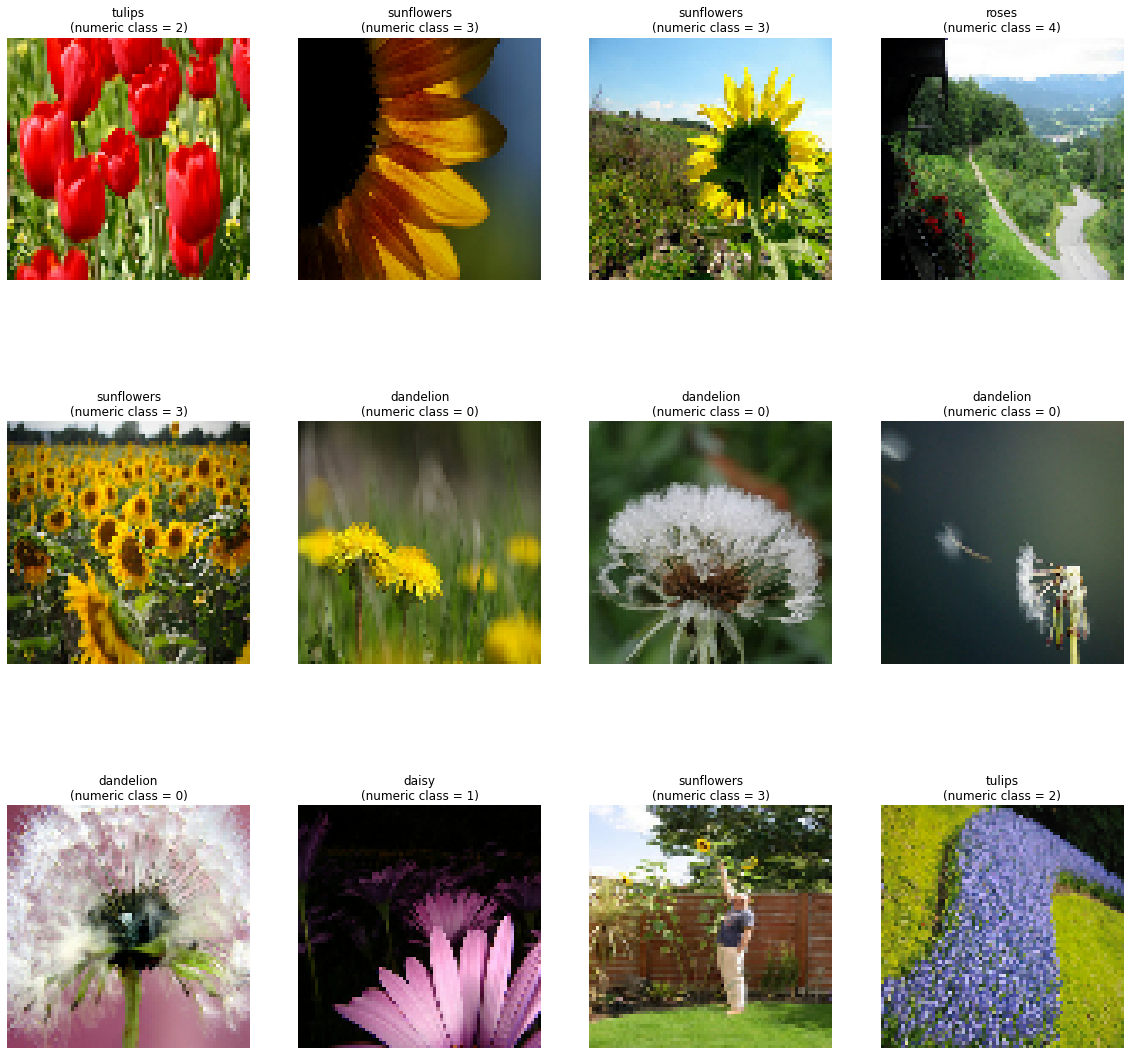

In [ ]:
# Visualize a few of the images. This starter code may be helpful if you later 
# want to show other images (e.g., those that are mis-classified). It also
# shows you how to see which class name is associated with which numeric label.
plt.figure(figsize=(20, 20))
subplot_num = 0
# unbatch() converts from the batched version back to an unbatched version
# take(12) tells it to iterate through 12 data points
for image, label in train_ds.unbatch().take(12):
  ax = plt.subplot(3, 4, subplot_num + 1)
  ax.imshow(image.numpy().astype("int32"))
  ax.set_title(info.features['label'].names[int(label)] + "\n(numeric class = " + str(int(label)) + ")")
  ax.axis("off")
  subplot_num += 1
plt.show()

In [ ]:
plt.figure(figsize=(60, 40))
subplot_num = 0
for image, label in validation_ds.unbatch().take(-1):
  if int(label) == 4:
    ax = plt.subplot(15, 8, subplot_num + 1)
    ax.imshow(image.numpy().astype("int32"))
    ax.set_title(info.features['label'].names[int(label)] + "\n(numeric class = " + str(int(label)) + ")")
    ax.axis("off")
    subplot_num += 1
plt.show()

In [ ]:
# The code above shows using `take` to get images and labels. If you wanted to get
# all labels for one of the datasets, you can use `take(-1)` (-1 tells it to get
# everything). 
# The line below makes a list of all the labels for the validation data and then
# prints out the number of instances of each class in the validation data.
validation_labels = []
for _, label in validation_ds.unbatch().take(-1):
  validation_labels.append(label)
#The line below is equivalent to the three lines above
#validation_labels = [label for _, label in train_ds.unbatch().take(-1)]
validation_labels = np.array(validation_labels)
for i, name in enumerate(info.features['label'].names):
  print(name + ":", sum(validation_labels == i))

print("total images in validation:", len(validation_labels))


dandelion: 89
daisy: 59
tulips: 101
sunflowers: 62
roses: 56
total images in validation: 367


That's it for my starter code! Please make sure you ask if you have any questions about any of it, and make sure you've read the handout about this assignment before you begin. The [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model) and the class materials are likely to be very helpful for this assignment.

Epoch 1/20
92/92 [==============================] - 1s 7ms/step - loss: 1.6955 - accuracy: 0.4070 - val_loss: 1.2088 - val_accuracy: 0.4714
Epoch 2/20
92/92 [==============================] - 1s 6ms/step - loss: 1.1373 - accuracy: 0.5150 - val_loss: 1.1468 - val_accuracy: 0.5041
Epoch 3/20
92/92 [==============================] - 1s 6ms/step - loss: 1.0662 - accuracy: 0.5640 - val_loss: 1.0826 - val_accuracy: 0.5504
Epoch 4/20
92/92 [==============================] - 1s 6ms/step - loss: 1.0215 - accuracy: 0.5964 - val_loss: 1.0781 - val_accuracy: 0.5858
Epoch 5/20
92/92 [==============================] - 1s 5ms/step - loss: 0.9932 - accuracy: 0.6001 - val_loss: 1.0251 - val_accuracy: 0.6022
Epoch 6/20
92/92 [==============================] - 1s 6ms/step - loss: 0.9630 - accuracy: 0.6230 - val_loss: 1.0337 - val_accuracy: 0.5913
Epoch 7/20
92/92 [==============================] - 1s 6ms/step - loss: 0.9451 - accuracy: 0.6403 - val_loss: 0.9912 - val_accuracy: 0.5995
Epoch 8/20
92/92 [==

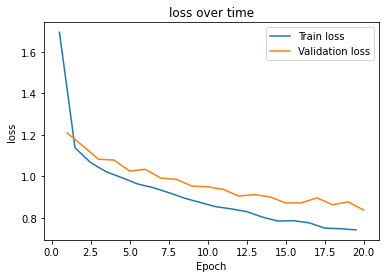

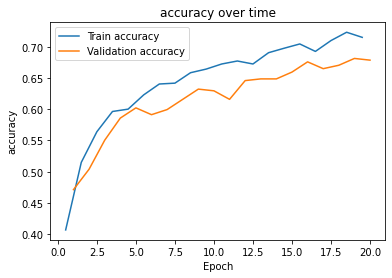

In [ ]:
def plot_performance(history, metrics = ["loss", "accuracy"]):
  for metric in metrics:
    plt.plot([i-.5 for i in range(1,epochs+1)], history.history[metric], label="Train " + metric)
    plt.plot(range(1,epochs+1), history.history["val_" + metric], label="Validation " + metric)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(metric + " over time")
    plt.show()

def create_model(rescale=False, use_convolutions=False, augmentation=False, modified=False):
  model = keras.Sequential()
  model.add(keras.Input(shape=(72, 72, 3)))
  

  if augmentation:
    flip_layer = layers.experimental.preprocessing.RandomFlip('horizontal')
    model.add(flip_layer)
    rotation_layer = layers.experimental.preprocessing.RandomRotation(.1)
    model.add(rotation_layer)
  if rescale:
    model.add(Rescaling(scale=2./255, offset=-1))
  if use_convolutions:
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
  if modified:
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=1024, kernel_size=(3,3), activation="relu"))
    # model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(128, activation="relu", name = "hidden_layer"))
  model.add(Dense(5, name = "output_layer"))

  model.compile(optimizer = 'adam', 
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics =['accuracy'])
  return model

epochs=20
'''
basic_model = create_model()
history_basic_model = basic_model.fit(train_ds, epochs=epochs, validation_data = validation_ds)
plot_performance(history_basic_model)

normalize_model = create_model(rescale=True)
history_normalize_model = normalize_model.fit(train_ds, epochs=epochs, validation_data = validation_ds)
plot_performance(history_normalize_model)

convolution_model = create_model(rescale=True,use_convolutions=True)
history_convolution_model = convolution_model.fit(train_ds, epochs=epochs, validation_data = validation_ds)
plot_performance(history_convolution_model)
'''
data_augmentation_model = create_model(rescale=True,use_convolutions=True,augmentation=True)
history_data_augmentation_model = data_augmentation_model.fit(train_ds, epochs=epochs, validation_data = validation_ds)
plot_performance(history_data_augmentation_model)



Epoch 1/20
92/92 [==============================] - 1s 8ms/step - loss: 1.2574 - accuracy: 0.4673 - val_loss: 1.0866 - val_accuracy: 0.5695
Epoch 2/20
92/92 [==============================] - 1s 7ms/step - loss: 1.0038 - accuracy: 0.5998 - val_loss: 0.9675 - val_accuracy: 0.6131
Epoch 3/20
92/92 [==============================] - 1s 7ms/step - loss: 0.9098 - accuracy: 0.6407 - val_loss: 0.8421 - val_accuracy: 0.6567
Epoch 4/20
92/92 [==============================] - 1s 7ms/step - loss: 0.8293 - accuracy: 0.6764 - val_loss: 0.7823 - val_accuracy: 0.6975
Epoch 5/20
92/92 [==============================] - 1s 7ms/step - loss: 0.7795 - accuracy: 0.6955 - val_loss: 0.7958 - val_accuracy: 0.6866
Epoch 6/20
92/92 [==============================] - 1s 7ms/step - loss: 0.7340 - accuracy: 0.7248 - val_loss: 0.7599 - val_accuracy: 0.7003
Epoch 7/20
92/92 [==============================] - 1s 7ms/step - loss: 0.6907 - accuracy: 0.7367 - val_loss: 0.7765 - val_accuracy: 0.6785
Epoch 8/20
92/92 [==

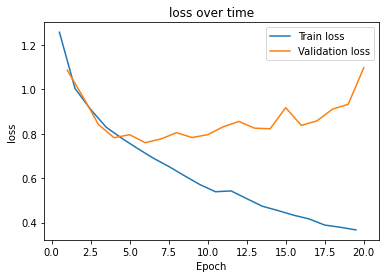

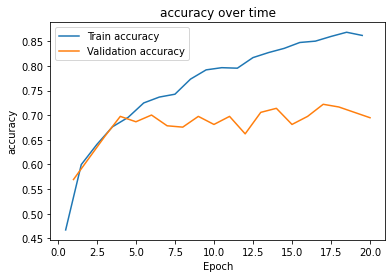

In [ ]:
modified_model = create_model(rescale=True, use_convolutions=True, augmentation=True, modified=True)
history_modified_model = modified_model.fit(train_ds, epochs=epochs, validation_data = validation_ds)
plot_performance(history_modified_model)

In [ ]:
# for BASIC MODELS

# basic_model 
# validation_ds is my validation dataset ( as made in the starter code )
validation_y = [label.numpy() for _, label in validation_ds.unbatch().take(-1)]
# results is a numpy array with the predicted class for each item in validation
results_basic = basic_model.predict(validation_ds)
results_basic = results_basic.argmax(axis=1)
confusion_matrix_basic = tf.math.confusion_matrix(validation_y, results_basic)
print(confusion_matrix_basic)

# normalize_model
# validation_ds is my validation dataset ( as made in the starter code )
validation_y = [label.numpy() for _, label in validation_ds.unbatch().take(-1)]
# results is a numpy array with the predicted class for each item in validation
results_normalize = normalize_model.predict(validation_ds)
results_normalize = results_normalize.argmax(axis=1)
confusion_matrix_normalize = tf.math.confusion_matrix(validation_y, results_normalize)
print(confusion_matrix_normalize)


# convolution_model
# validation_ds is my validation dataset ( as made in the starter code )
# results is a numpy array with the predicted class for each item in validation
results_convolution = convolution_model.predict(validation_ds)
results_convolution = results_convolution.argmax(axis=1)
confusion_matrix_convolution = tf.math.confusion_matrix(validation_y, results_convolution)
print(confusion_matrix_convolution)

# data_augmentation_model
# validation_ds is my validation dataset ( as made in the starter code )
# results is a numpy array with the predicted class for each item in validation
results_data_augmentation = data_augmentation_model.predict(validation_ds)
results_data_augmentation = results_data_augmentation.argmax(axis=1)
confusion_matrix_data_augmentation = tf.math.confusion_matrix(validation_y, results_data_augmentation)
print(confusion_matrix_data_augmentation)



NameError: ignored

In [ ]:
# validation_ds is my validation dataset ( as made in the starter code )
validation_y = [label.numpy() for _, label in validation_ds.unbatch().take(-1)]
# results is a numpy array with the predicted class for each item in validation
results = modified_model.predict(validation_ds)
results = results.argmax(axis=1)
confusion_matrix = tf.math.confusion_matrix(validation_y, results)
array_4 = []
array_14 = []
for i in range(len(results)):
   if validation_y[i] == 2 and results[i] == 4:
     array_14.append(i)
     array_4.append(i)
   elif validation_y[i] == 4:
     array_4.append(i)
for i in range(len(array_4)):
   if array_4[i] in array_14:
     print(i)
print(confusion_matrix)

1
3
4
11
14
20
21
22
29
32
33
35
39
40
43
46
52
54
60
62
64
65
66
77
tf.Tensor(
[[63 14  4  6  2]
 [ 2 52  1  1  3]
 [ 4  4 62  7 24]
 [ 3  1  4 53  1]
 [ 4  7  7  1 37]], shape=(5, 5), dtype=int32)
